In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, tqdm
from sklearn.metrics import (mean_absolute_error,
                             mean_squared_error,
                             r2_score)

In [2]:
def parity_plot(label, pred, 
                plot_type, 
                xlabel='$\Delta E$ [eV]', 
                ylabel='$\Delta \hat{E}$ [eV]', 
                margin=False, color=None,
                xylim= [-7, 2]):
    '''
    targets_pred: x value
    targets_val: y value 
    residuals: targets_pred - targets_val 
    plot_type: hexabin / scatter
    xlabel: x-label name
    ylabel: y-label name
    delta: unit dE if True, unit E if False
    color: customize the color
    '''
    # Plot
    residuals = pred - label
    lims = xylim #[min(min(label), min(pred)) - 0.5, max(max(label), max(pred)) + 0.5]
    # lims = xylim
    if plot_type == 'hexabin':
        grid = sns.jointplot(x=label, 
                             y=pred,
                             kind='hex',
                             bins='log',
                             extent=lims+lims, 
                             color=color)
        
    elif plot_type == 'scatter':
        grid = sns.jointplot(x=label, 
                             y=pred, 
                             kind='scatter',
                             color=color)
        
    ax = grid.ax_joint
    _ = ax.set_xlim(lims)
    _ = ax.set_ylim(lims)
    _ = ax.plot(lims, lims, '--', c='grey')
    _ = ax.set_xlabel(f'{xlabel}', fontsize=16)
    _ = ax.set_ylabel(f'{ylabel}', fontsize=16)
    
    # Calculate the error metrics
    mae = mean_absolute_error(label, pred)
    rmse = np.sqrt(mean_squared_error(label, pred))
    r2 = r2_score(label, pred)
    
    # Report
    text = ('\n' +
            '  $R^2$ = %.2f\n' % r2 +
            '  MAE = %.2f eV\n' % mae + 
            '  RMSE = %.2f eV\n' % rmse
            )
    
    _ = ax.text(x=lims[0], y=lims[1], s=text,
                horizontalalignment='left',
                verticalalignment='top', fontsize=14)
    if margin == False:
        grid.ax_marg_x.remove()
        grid.ax_marg_y.remove()
        plt.axvline(lims[1], c='k', lw=2.2)
        plt.axhline(lims[1], c='k', lw=1.0)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    return r2, mae, rmse

In [2]:
mapping = pd.read_pickle('/home/jovyan/ocp2023/oc20_dense_metadata/oc20dense_mapping.pkl')

In [3]:
model = 'gnoc'
enhancement = 'base'
#checkpoint = 'rebase3-vanilla-catberta_1223_1537'

In [4]:
model_key_mapping = {'scn': 'scn-2M', 'escn': 'escn-2M', 'gnoc': 'gemnet-oc-2M'}
checkpoint_mapping = {'base':'rebase3-vanilla-catberta_1223_1537', 
                      'ca':'rebase3-da-catberta_1224_1518', 
                      'gap':'rebase-gap-catberta_1221_2208', 
                      'ca_gap':'rebase-da-gap-catberta_1226_0542'}

In [12]:
data_path = "/home/jovyan/shared-scratch/jhoon/ocp2023/clip_data"
data = pd.read_pickle(data_path + f"/oc20dense_eval_{model}_relaxed.pkl")

In [13]:
pred_path = f"/home/jovyan/shared-scratch/jhoon/ocp2023/results/ml-relax-pred/{model}/{checkpoint_mapping[enhancement]}"
pred = np.load(pred_path + "/pred.npz")
ids = pred['ids']
energy = pred['energy']

# Create a dictionary mapping from ids to energy
pred_dict = dict(zip(ids, energy))

In [14]:
dft = pd.read_pickle('/home/jovyan/ocp2023/AdsorbML/adsorbml/2023_neurips_challenge/ml_relaxed_dft_targets.pkl')[model_key_mapping[model]]
#label= np.array([dft[mapping[sid]['system_id']][config_id] for id in ids])

In [15]:
preds, labels = [], []
for id in tqdm.tqdm(data['id']):
    
    sid = int(id.split('_')[0])
    system_id = mapping[sid]['system_id']
    config_id = mapping[sid]['config_id']
    label = dft[system_id][config_id]
    # exclude the outliers
    # if label > 100:
    #     continue
    labels.append(label)
    preds.append(pred_dict[id])

100%|██████████| 11508/11508 [00:00<00:00, 525984.84it/s]


In [16]:
# count label value > 100
print('Number of total data: ', len(labels))
print('Number of outliers: ', np.sum(np.array(labels) > 100))
print('Number of valid data: ', len(labels) - np.sum(np.array(labels) > 100))

Number of total data:  11508
Number of outliers:  10589
Number of valid data:  919


In [17]:
def get_system_id(row, mapping):
    id_key = int(row['id'].split('_')[0])
    return mapping[id_key]['system_id'] if id_key in mapping else None

In [18]:
# Add a 'pred' column to the dataframe, mapping the energy values based on the 'id'
# data['pred'] = data['id'].map(pred_dict)

data['label'] = labels
data['pred'] = preds
# Apply the function to each row in the dataframe to create the 'sid' column
data['sid'] = data.apply(get_system_id, mapping=mapping, axis=1)
data = data[data['label']<=100]
# data.drop(columns=['chg_emb'], inplace=True)

In [19]:
data

,id,text,chg_emb,target,label,pred,sid
23,80130_108,CH</s>Nb18Se24 (1 0 1)</s>[C Nb Nb bridge [Nb ...,"[-12.062700271606445, 15.242162704467773, -0.5...",-2.063428,-2.116758,-1.354707,6_1511_60
41,53054_169,O</s>Ga36Pd36 (2 1 0)</s>[O Ga Ga bridge [Ga P...,"[39.30881881713867, -37.96696853637695, -59.97...",0.054117,0.289672,0.238334,0_3577_7
56,77488_230,NH2N(CH3)2</s>Hf48Al32 (1 0 0)</s>[N Hf atop [...,"[63.038841247558594, 17.94477653503418, -37.44...",-4.360986,-4.346853,-4.157249,58_2492_73
77,73449_216,NH2N(CH3)2</s>W108C48 (1 0 -1)</s>[N W atop [W...,"[-32.645084381103516, -29.357040405273438, -81...",-5.077691,-4.632463,-4.984260,58_1664_84
83,54376_235,H</s>Ti72Ni96 (2 -1 2)</s>[],"[28.0632266998291, 56.104190826416016, -120.20...",-0.648173,-0.583314,-0.010866,1_1041_93
...,...,...,...,...,...,...,...
11444,22516_-1,CCH</s>Sc4Fe24Ge24 (1 1 1)</s>[C Sc Fe bridge ...,"[24.2982234954834, -10.199527740478516, -14.06...",-3.004370,-2.981267,-2.496846,19_6336_4
11446,66585_189,COCH2OH</s>Nb24Ru48Si24 (2 1 0)</s>[C Nb Si br...,"[29.651254653930664, -11.10466480255127, -98.8...",-3.405258,-3.513478,-3.147947,41_9852_9
11452,76075_223,CHCO</s>Zr16Cd48 (1 1 0)</s>[],"[32.856815338134766, 20.9436092376709, -35.043...",-1.666548,-1.607023,-1.710745,20_2689_4
11461,37616_286,COCH2OH</s>Ti5P20W15 (2 1 2)</s>[C W atop [W T...,"[5.1578145027160645, -2.5046024322509766, -30....",-3.963542,-3.971891,-3.521285,41_9937_40


# Text Duplicates

In [20]:
# Identifying duplicates in the 'sid' column
text_duplicates = data[data.duplicated('text', keep=False)]

# Keeping only the non-duplicates
text_non_duplicates = data[~data.duplicated('text', keep=False)]

print('Number of duplicates: ', len(text_duplicates))
print('Number of non-duplicates: ', len(text_non_duplicates))

Number of duplicates:  575
Number of non-duplicates:  344


In [22]:
# save text_duplicates and text_non_duplicates
text_duplicates.to_pickle(data_path + f"/eval_{model}_dup.pkl")
text_non_duplicates.to_pickle(data_path + f"/eval_{model}_non_dup.pkl")

## analysis and plot

0.8863801555230779 0.3455323820140051 0.49553846422018316


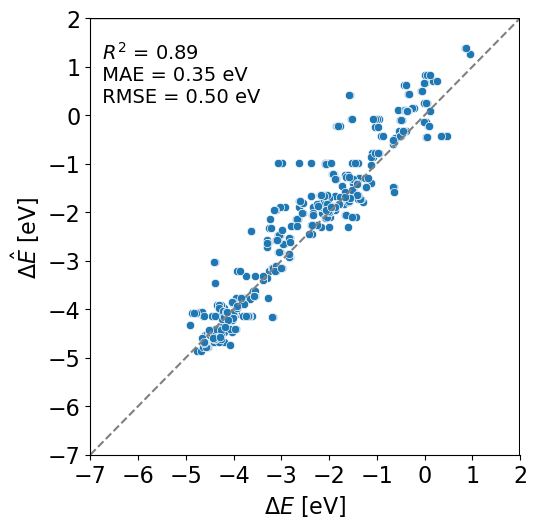

In [118]:
labels = text_duplicates['target']
preds = text_duplicates['pred']

r2, mae, rmse = parity_plot(labels, preds, plot_type='scatter')
print(r2, mae, rmse)

0.7865290430414479 0.3983011224529121 0.5876982172346285


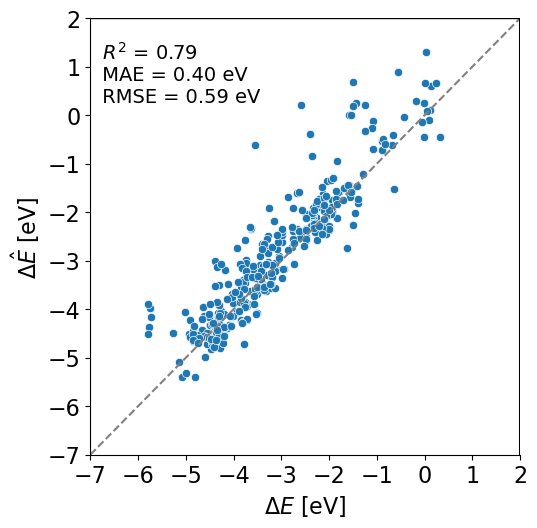

In [119]:
labels = text_non_duplicates['target']
preds = text_non_duplicates['pred']

r2, mae, rmse = parity_plot(labels, preds, plot_type='scatter')
print(r2, mae, rmse)
# save the plot
# save_path = os.path.join('parity_plot.png')
# plt.savefig(save_path, bbox_inches='tight', facecolor='w')

In [104]:
def parity_plot2(label_dup, pred_dup, label_nondup, pred_nondup, 
                 xlabel='$\Delta E$ [eV]', ylabel='$\Delta \hat{E}$ [eV]',
                 margin=False, colors=['red', 'blue'], xylim= [-7, 2], alpha=0.5):
    '''
    label_dup, pred_dup: labels and predictions for duplicate text set
    label_nondup, pred_nondup: labels and predictions for unique text set
    xlabel: x-label name
    ylabel: y-label name
    colors: list containing colors for duplicate and unique text sets
    xylim: x and y limits for the plot
    alpha: transparency level for scatter plots
    '''
    # Calculate the error metrics for duplicate and unique text sets
    mae_dup = mean_absolute_error(label_dup, pred_dup)
    rmse_dup = np.sqrt(mean_squared_error(label_dup, pred_dup))
    r2_dup = r2_score(label_dup, pred_dup)

    mae_nondup = mean_absolute_error(label_nondup, pred_nondup)
    rmse_nondup = np.sqrt(mean_squared_error(label_nondup, pred_nondup))
    r2_nondup = r2_score(label_nondup, pred_nondup)

    # Plot
    lims = xylim

    plt.figure(figsize=(6, 6))
    plt.scatter(label_dup, pred_dup, 
                color=colors[0], alpha=alpha, 
                label=f'Duplicate text set (MAE = {mae_dup:.2f} eV)')
    plt.scatter(label_nondup, pred_nondup, 
                color=colors[1], alpha=alpha, 
                label=f'Unique text set (MAE = {mae_nondup:.2f} eV)')

    plt.plot(lims, lims, '--', c='grey')
    plt.xlim(lims)
    plt.ylim(lims)
    plt.xlabel(xlabel, fontsize=18)
    plt.ylabel(ylabel, fontsize=18)
    plt.legend(fontsize=14, loc='lower left')

    if not margin:
        plt.axvline(lims[1], c='k', lw=0.8)
        plt.axhline(lims[1], c='k', lw=0.8)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    # plt.show()
    return (r2_dup, r2_nondup), (mae_dup, mae_nondup), (rmse_dup, rmse_nondup)
# Example usage of the function
# parity_plot2(label_dup, pred_dup, label_nondup, pred_nondup)


(0.8863801555230779, 0.7865290430414479) (0.3455323820140051, 0.3983011224529121) (0.49553846422018316, 0.5876982172346285)


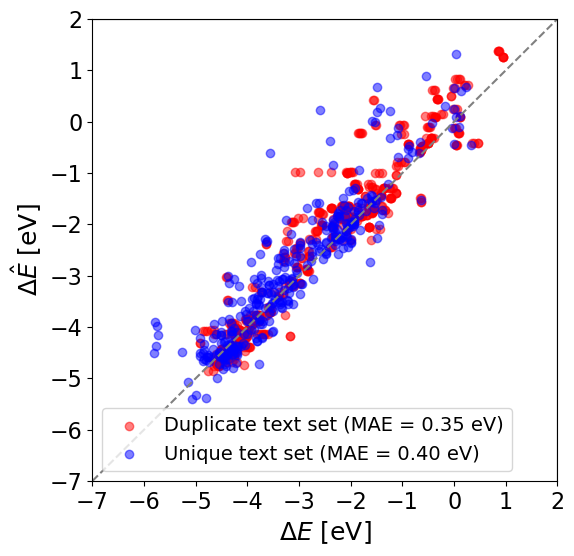

In [120]:
labels_dup = text_duplicates['target']
preds_dup = text_duplicates['pred']


labels_nondup = text_non_duplicates['target']
preds_nondup = text_non_duplicates['pred']

r2, mae, rmse = parity_plot2(labels_dup, preds_dup, labels_nondup, preds_nondup)

save_path = f"duplicate/{model}_{enhancement}" #os.path.join('parity_plot.png')
# save the plot
plt.savefig(save_path+'.png', bbox_inches='tight', facecolor='w')

# save r2, mae, rmse as text file
with open(save_path+'.txt', 'w') as f:
    f.write(f'r2: {r2}\n')
    f.write(f'mae: {mae}\n')
    f.write(f'rmse: {rmse}\n')
print(r2, mae, rmse)

## statistics

In [200]:
# Grouping the dataframe by 'text', counting occurrences, and collecting 'id's
text_duplicate_counts = data.groupby('text').agg(
    count=('text', 'size'),
    sids=('id', lambda ids: list(ids))
).reset_index()

# Filtering to keep only the texts with more than one occurrence (duplicates)
text_duplicate_counts = text_duplicate_counts[text_duplicate_counts['count'] > 1]

# Sorting the dataframe by 'count' in descending order
text_duplicate_counts = text_duplicate_counts.sort_values(by='count', ascending=False)
text_duplicate_counts

,text,count,sids
525,OHCH3</s>Zn52Fe4 (0 1 0)</s>[],5,"[30623_230, 51172_-1, 18927_-1, 52208_199, 327..."
264,COCH2OH</s>Cu64 (1 0 1)</s>[C Cu atop [Cu Cu C...,5,"[4626_-1, 57505_272, 21053_-1, 64423_-1, 80252..."
494,NH2N(CH3)2</s>Ti48Pt80 (0 2 1)</s>[N Ti atop [...,5,"[47777_185, 64867_-1, 71663_235, 42036_-1, 838..."
129,CH</s>K6Fe16Se16 (1 1 2)</s>[C Fe Fe bridge [F...,5,"[85053_128, 32544_269, 61757_111, 69421_123, 3..."
491,NH2N(CH3)2</s>Sr16Cd16Ga16 (1 2 0)</s>[],5,"[50722_-1, 18926_-1, 6234_-1, 35640_-1, 71873_-1]"
...,...,...,...
208,CHCO</s>Hf20In20Ni40 (2 2 1)</s>[C Hf Ni bridg...,2,"[76760_224, 50571_-1]"
206,CHCO</s>Hf20In20Ni40 (2 2 1)</s>[C Hf Ni bridg...,2,"[17288_-1, 63073_252]"
193,CHCH</s>Pd72Sb36 (0 2 1)</s>[C Pd Pd bridge [P...,2,"[65179_217, 57729_188]"
185,CHCH</s>Ir32Zr32 (2 1 1)</s>[C Ir Zr Zr hollow...,2,"[80307_217, 27333_188]"


In [201]:
# Retrieve the list of ids for the third row in text_duplicate_counts
ids_to_filter = text_duplicate_counts.iloc[3]['sids']

# Create a subset of 'data' where 'id' matches any of the ids in ids_to_filter
subset_data = data[data['id'].isin(ids_to_filter)]
subset_data

,id,text,target,label,pred,sid
1647,85053_128,CH</s>K6Fe16Se16 (1 1 2)</s>[C Fe Fe bridge [F...,-2.146465,-2.055839,-1.643455,6_11104_287
2495,32544_269,CH</s>K6Fe16Se16 (1 1 2)</s>[C Fe Fe bridge [F...,-2.180811,-2.034965,-1.643455,6_11104_287
6343,61757_111,CH</s>K6Fe16Se16 (1 1 2)</s>[C Fe Fe bridge [F...,-2.166703,-2.048903,-1.643455,6_11104_287
8319,69421_123,CH</s>K6Fe16Se16 (1 1 2)</s>[C Fe Fe bridge [F...,-2.176072,-2.010651,-1.643455,6_11104_287
10641,36958_181,CH</s>K6Fe16Se16 (1 1 2)</s>[C Fe Fe bridge [F...,-2.163699,-2.049132,-1.643455,6_11104_287


In [202]:
subset_data.iloc[0]['text']

'CH</s>K6Fe16Se16 (1 1 2)</s>[C Fe Fe bridge [Fe Fe Fe Se Se Se C] [Fe Fe Fe Fe Se Se C]]'

(-2885.9443170294253, 0.6380894422531128, 0.6381999839174899)

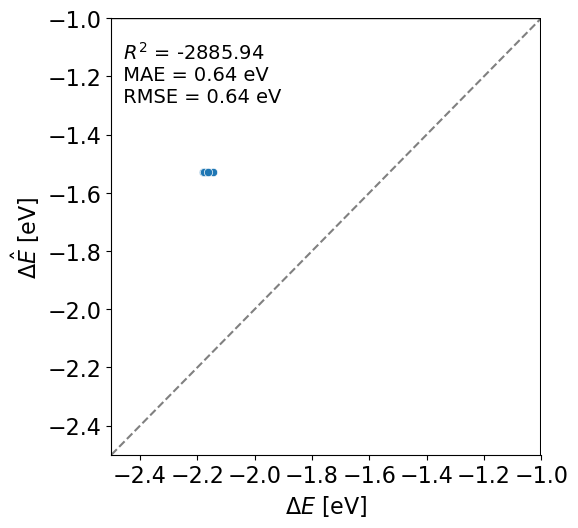

In [159]:
parity_plot(subset_data['target'], subset_data['pred'], 
            plot_type='scatter', xylim= [-2.5, -1])

In [132]:
# Retrieve the list of ids for the third row in text_duplicate_counts
ids_to_filter = text_duplicate_counts.iloc[3]['sids']

# Create a subset of 'data' where 'id' matches any of the ids in ids_to_filter
subset_data = data[data['id'].isin(ids_to_filter)]
subset_data

,id,text,target,label,pred,sid
1647,85053_128,CH</s>K6Fe16Se16 (1 1 2)</s>[C Fe Fe bridge [F...,-2.146465,-2.055839,-1.643455,6_11104_287
2495,32544_269,CH</s>K6Fe16Se16 (1 1 2)</s>[C Fe Fe bridge [F...,-2.180811,-2.034965,-1.643455,6_11104_287
6343,61757_111,CH</s>K6Fe16Se16 (1 1 2)</s>[C Fe Fe bridge [F...,-2.166703,-2.048903,-1.643455,6_11104_287
8319,69421_123,CH</s>K6Fe16Se16 (1 1 2)</s>[C Fe Fe bridge [F...,-2.176072,-2.010651,-1.643455,6_11104_287
10641,36958_181,CH</s>K6Fe16Se16 (1 1 2)</s>[C Fe Fe bridge [F...,-2.163699,-2.049132,-1.643455,6_11104_287


In [157]:
enhancement

'base'

(-1940.9694843321179, 0.5232954263687134, 0.5234302116001801)

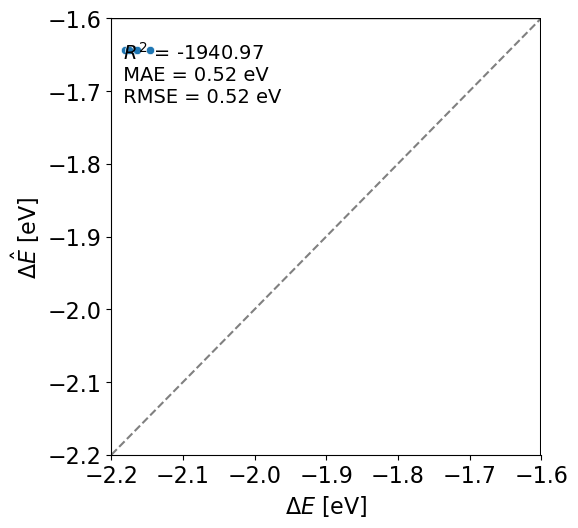

In [141]:
parity_plot(subset_data['target'], subset_data['pred'], 
            plot_type='scatter', xylim= [-2.2, -1.6])

In [123]:
# Grouping the dataframe by 'text', counting occurrences, and collecting 'id's
text_duplicate_counts = data.groupby('text').agg(
    count=('text', 'size'),
    sids=('sid', lambda sids: list(set(sids)))
).reset_index()

# Filtering to keep only the texts with more than one occurrence (duplicates)
text_duplicate_counts = text_duplicate_counts[text_duplicate_counts['count'] > 1]

# Sorting the dataframe by 'count' in descending order
text_duplicate_counts = text_duplicate_counts.sort_values(by='count', ascending=False)
text_duplicate_counts

,text,count,sids
525,OHCH3</s>Zn52Fe4 (0 1 0)</s>[],5,[16_834_196]
264,COCH2OH</s>Cu64 (1 0 1)</s>[C Cu atop [Cu Cu C...,5,[41_90_8]
494,NH2N(CH3)2</s>Ti48Pt80 (0 2 1)</s>[N Ti atop [...,5,[58_1143_83]
129,CH</s>K6Fe16Se16 (1 1 2)</s>[C Fe Fe bridge [F...,5,[6_11104_287]
491,NH2N(CH3)2</s>Sr16Cd16Ga16 (1 2 0)</s>[],5,[58_8622_75]
...,...,...,...
208,CHCO</s>Hf20In20Ni40 (2 2 1)</s>[C Hf Ni bridg...,2,[20_11080_4]
206,CHCO</s>Hf20In20Ni40 (2 2 1)</s>[C Hf Ni bridg...,2,[20_11080_4]
193,CHCH</s>Pd72Sb36 (0 2 1)</s>[C Pd Pd bridge [P...,2,[25_365_161]
185,CHCH</s>Ir32Zr32 (2 1 1)</s>[C Ir Zr Zr hollow...,2,[25_2691_7]


In [26]:
# Grouping the dataframe by 'sid' and counting the occurrences of each
text_duplicate_counts = data.groupby('text').size().reset_index(name='count')

# Filtering to keep only the sids with more than one occurrence (duplicates)
text_duplicate_counts = text_duplicate_counts[text_duplicate_counts['count'] > 1]

# Sorting the duplicate_counts dataframe by 'count' in descending order
text_duplicate_counts = text_duplicate_counts.sort_values(by='count', ascending=False)
text_duplicate_counts

,text,count
3749,H</s>Ti72Ni96 (2 -1 2)</s>[],183
3678,H</s>Ca16Ga32 (2 0 1)</s>[],81
3713,H</s>Ti24Ni24 (0 1 1)</s>[],81
3882,O</s>Cd24Pd8 (1 0 0)</s>[],68
2626,COCH2OH</s>Au48Bi24 (1 1 1)</s>[C Au atop [Au C]],61
...,...,...
2362,CHCH</s>Ti36Re18Os18 (0 0 1)</s>[C Re Re bridg...,2
500,CC</s>Zr32Cd32 (2 2 1)</s>[C Zr Zr bridge [Zr ...,2
2381,CHCH</s>Ti36Re18Os18 (0 0 1)</s>[C Re atop [Re...,2
2387,CHCO</s>Hf20In20Ni40 (2 2 1)</s>[C Hf Hf bridg...,2


# SID Duplicates

In [132]:
# Identifying duplicates in the 'sid' column
duplicates = data[data.duplicated('sid', keep=False)]

# Keeping only the non-duplicates
non_duplicates = data[~data.duplicated('sid', keep=False)]

In [133]:
duplicates

,id,text,target,label,pred,sid
23,80130_108,CH</s>Nb18Se24 (1 0 1)</s>[C Nb Nb bridge [Nb ...,-2.063428,-2.116758,-1.354707,6_1511_60
41,53054_169,O</s>Ga36Pd36 (2 1 0)</s>[O Ga Ga bridge [Ga P...,0.054117,0.289672,0.238334,0_3577_7
56,77488_230,NH2N(CH3)2</s>Hf48Al32 (1 0 0)</s>[N Hf atop [...,-4.360986,-4.346853,-4.157249,58_2492_73
77,73449_216,NH2N(CH3)2</s>W108C48 (1 0 -1)</s>[N W atop [W...,-5.077691,-4.632463,-4.984260,58_1664_84
83,54376_235,H</s>Ti72Ni96 (2 -1 2)</s>[],-0.648173,-0.583314,-0.010866,1_1041_93
...,...,...,...,...,...,...
11444,22516_-1,CCH</s>Sc4Fe24Ge24 (1 1 1)</s>[C Sc Fe bridge ...,-3.004370,-2.981267,-2.496846,19_6336_4
11446,66585_189,COCH2OH</s>Nb24Ru48Si24 (2 1 0)</s>[C Nb Si br...,-3.405258,-3.513478,-3.147947,41_9852_9
11452,76075_223,CHCO</s>Zr16Cd48 (1 1 0)</s>[],-1.666548,-1.607023,-1.710745,20_2689_4
11461,37616_286,COCH2OH</s>Ti5P20W15 (2 1 2)</s>[C W atop [W T...,-3.963542,-3.971891,-3.521285,41_9937_40


In [134]:
non_duplicates

,id,text,target,label,pred,sid
3913,53942_186,CH4</s>Co36Y48 (2 1 1)</s>[],-3.052275,-2.683564,-3.054943,15_3994_47
8994,83985_95,CH</s>Ca16Ga32 (1 1 0)</s>[C Ca Ca bridge [Ca ...,-0.428895,-0.021951,-1.912305,6_1444_4


In [20]:
# Grouping the dataframe by 'sid' and counting the occurrences of each
duplicate_counts = data.groupby('sid').size().reset_index(name='count')

# Filtering to keep only the sids with more than one occurrence (duplicates)
duplicate_counts = duplicate_counts[duplicate_counts['count'] > 1]

# Sorting the duplicate_counts dataframe by 'count' in descending order
duplicate_counts = duplicate_counts.sort_values(by='count', ascending=False)

In [21]:
duplicate_counts

,sid,count
41,1_1041_93,286
31,17_2568_4,234
7,10_3099_33,183
63,25_1958_61,179
33,17_3066_19,178
...,...,...
26,15_9991_19,5
27,16_4335_2,3
157,58_833_10,2
196,6_362_7,2
